In [1]:
# ============================================================================
# EXPERIMENT 2: Vanilla Supervised Fine-Tuning
# ============================================================================


In [2]:
# --- CELL 1: Install Dependencies ---
!pip install transformers>=4.35.0 datasets>=2.14.0 accelerate>=0.24.0 torch>=2.0.0 tqdm matplotlib -q

In [3]:
# --- CELL 2: Import Libraries ---
import torch
import re
import os
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

from huggingface_hub import login
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

In [4]:
# --- CELL 3: Hugging Face Login ---
print("Please log in to Hugging Face...")
login()

Please log in to Hugging Face...


In [6]:
# --- CELL 4: Configuration ---
class Config:
    # Model
    MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
    
    # Dataset
    USE_SUBSET = False
    TRAIN_SUBSET_SIZE = 100
    TEST_SUBSET_SIZE = 50
    
    # Output
    OUTPUT_DIR = "./small_project/vanilla_sft"
    
    # Training
    NUM_EPOCHS = 2
    BATCH_SIZE = 2
    GRADIENT_ACCUMULATION_STEPS = 8
    LEARNING_RATE = 2e-5  # Increased for faster learning
    MAX_LENGTH = 512  # Reduced to fit more in memory
    
    # Generation
    GENERATION_MAX_NEW_TOKENS = 256
    TEMPERATURE = 0.7
    TOP_P = 0.9

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{config.OUTPUT_DIR}/checkpoints", exist_ok=True)
os.makedirs(f"{config.OUTPUT_DIR}/logs", exist_ok=True)

print(f"{'='*80}")
print(f"VANILLA SFT CONFIGURATION")
print(f"{'='*80}")
print(f"Model: {config.MODEL_NAME}")
print(f"Training samples: {config.TRAIN_SUBSET_SIZE if config.USE_SUBSET else 'Full'}")
print(f"Test samples: {config.TEST_SUBSET_SIZE if config.USE_SUBSET else 'Full'}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Output: {config.OUTPUT_DIR}")
print(f"{'='*80}\n")

VANILLA SFT CONFIGURATION
Model: meta-llama/Llama-3.2-3B-Instruct
Training samples: Full
Test samples: Full
Epochs: 2
Learning rate: 2e-05
Output: ./small_project/vanilla_sft



In [7]:
# --- CELL 5: Data Functions ---
def extract_answer(text):
    """Extract numerical answer from text with multiple fallback strategies"""
    if not text:
        return None
    
    # Strategy 1: Find #### format
    match = re.search(r'####\s*(-?\d+(?:,\d+)*(?:\.\d+)?)', text)
    if match:
        return match.group(1).replace(',', '')
    
    # Strategy 2: Find "answer is X" or "= X"
    patterns = [
        r'answer is[:\s]+(-?\d+(?:,\d+)*(?:\.\d+)?)',
        r'=\s*(-?\d+(?:,\d+)*(?:\.\d+)?)\s*$',
        r'total[:\s]+(-?\d+(?:,\d+)*(?:\.\d+)?)',
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).replace(',', '')
    
    # Strategy 3: Last number in text
    numbers = re.findall(r'-?\d+(?:,\d+)*(?:\.\d+)?', text)
    if numbers:
        return numbers[-1].replace(',', '')
    
    return None

def create_training_prompt(question, solution):
    """Create training prompt in chat format"""
    # Clean solution: ensure it has #### format
    clean_solution = solution.strip()
    if '####' not in clean_solution:
        answer = extract_answer(clean_solution)
        if answer:
            clean_solution = f"{clean_solution}\n#### {answer}"
    
    # Use a clear, consistent format
    prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Solve this math problem step by step and provide the final answer after ####.

{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{clean_solution}<|eot_id|>"""
    
    return prompt

def create_inference_prompt(question):
    """Create prompt for inference (without answer)"""
    prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Solve this math problem step by step and provide the final answer after ####.

{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""
    return prompt

def load_gsm8k_data():
    """Load and preprocess GSM8K dataset"""
    print("Loading GSM8K dataset...")
    dataset = load_dataset("gsm8k", "main")
    
    train_data = []
    for item in tqdm(dataset["train"], desc="Processing train"):
        answer = extract_answer(item["answer"])
        if answer:  # Only include if we can extract answer
            train_data.append({
                "question": item["question"],
                "solution": item["answer"],
                "answer": answer
            })
    
    test_data = []
    for item in tqdm(dataset["test"], desc="Processing test"):
        answer = extract_answer(item["answer"])
        if answer:
            test_data.append({
                "question": item["question"],
                "solution": item["answer"],
                "answer": answer
            })
    
    print(f"✓ Loaded {len(train_data)} train and {len(test_data)} test examples")
    return train_data, test_data

In [8]:
# --- CELL 6: Load Data ---
full_train_data, full_test_data = load_gsm8k_data()

if config.USE_SUBSET:
    train_data = full_train_data[:config.TRAIN_SUBSET_SIZE]
    test_data = full_test_data[:config.TEST_SUBSET_SIZE]
    print(f"\n→ Using subset: {len(train_data)} train, {len(test_data)} test")
else:
    train_data = full_train_data
    test_data = full_test_data
    print(f"\n→ Using full dataset: {len(train_data)} train, {len(test_data)} test")

# Save raw data
print("\nSaving raw data...")
with open(f"{config.OUTPUT_DIR}/train_data.json", "w") as f:
    json.dump(train_data, f, indent=2)
with open(f"{config.OUTPUT_DIR}/test_data.json", "w") as f:
    json.dump(test_data, f, indent=2)
print(f"✓ Saved to {config.OUTPUT_DIR}/train_data.json and test_data.json")

# Show sample
print("\n" + "="*80)
print("SAMPLE TRAINING FORMAT")
print("="*80)
sample = create_training_prompt(train_data[0]["question"], train_data[0]["solution"])
print(sample[:500] + "..." if len(sample) > 500 else sample)
print("="*80)

Loading GSM8K dataset...


Processing train:   0%|          | 0/7473 [00:00<?, ?it/s]

Processing test:   0%|          | 0/1319 [00:00<?, ?it/s]

✓ Loaded 7473 train and 1319 test examples

→ Using full dataset: 7473 train, 1319 test

Saving raw data...
✓ Saved to ./small_project/vanilla_sft/train_data.json and test_data.json

SAMPLE TRAINING FORMAT
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Solve this math problem step by step and provide the final answer after ####.

Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72<|eot_id|>


In [9]:
# --- CELL 7: Initialize Model and Tokenizer ---
print("\nLoading base model and tokenizer...")
model = AutoModelForCausalLM.from_pretrained(
    config.MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    use_cache=False  # Required for gradient checkpointing
)

tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"✓ Model loaded on: {model.device}")
print(f"✓ Model dtype: {model.dtype}")
print(f"✓ Tokenizer vocab size: {len(tokenizer)}")

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()
print("✓ Gradient checkpointing enabled")

`torch_dtype` is deprecated! Use `dtype` instead!



Loading base model and tokenizer...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded on: cuda:0
✓ Model dtype: torch.bfloat16
✓ Tokenizer vocab size: 128256
✓ Gradient checkpointing enabled


In [10]:
# --- CELL 8: Prepare Training Dataset ---
def prepare_dataset(data, tokenizer):
    """Prepare and tokenize dataset"""
    
    # Format all examples
    formatted_texts = []
    for item in tqdm(data, desc="Formatting examples"):
        text = create_training_prompt(item["question"], item["solution"])
        formatted_texts.append({"text": text})
    
    # Create dataset
    dataset = Dataset.from_list(formatted_texts)
    
    # Tokenize
    def tokenize_function(examples):
        # Tokenize
        result = tokenizer(
            examples["text"],
            truncation=True,
            max_length=config.MAX_LENGTH,
            padding="max_length",
            return_tensors=None,
        )
        # Labels are same as input_ids for causal LM
        result["labels"] = result["input_ids"].copy()
        return result
    
    tokenized = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names,
        desc="Tokenizing",
    )
    
    print(f"✓ Created dataset with {len(tokenized)} examples")
    return tokenized

print("\nPreparing training dataset...")
train_dataset = prepare_dataset(train_data, tokenizer)

# Save a few tokenized examples for debugging
print("\nSample tokenized example:")
sample_ids = train_dataset[0]["input_ids"][:50]
print(f"Input IDs (first 50): {sample_ids}")
print(f"Decoded: {tokenizer.decode(sample_ids)}")


Preparing training dataset...


Formatting examples:   0%|          | 0/7473 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/7473 [00:00<?, ? examples/s]

✓ Created dataset with 7473 examples

Sample tokenized example:
Input IDs (first 50): [128000, 128000, 128006, 882, 128007, 271, 50, 4035, 420, 7033, 3575, 3094, 555, 3094, 323, 3493, 279, 1620, 4320, 1306, 27370, 382, 45, 4306, 689, 6216, 27203, 311, 220, 2166, 315, 1077, 4885, 304, 5936, 11, 323, 1243, 1364, 6216, 4376, 439, 1690, 27203, 304, 3297, 13, 2650, 1690, 27203]
Decoded: <|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

Solve this math problem step by step and provide the final answer after ####.

Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips


In [11]:
# --- CELL 9: Custom Training Callback ---
class LoggingCallback(TrainerCallback):
    """Callback to log training progress"""
    
    def __init__(self, log_file):
        self.log_file = log_file
        self.logs = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            log_entry = {
                "step": state.global_step,
                "epoch": state.epoch,
                **logs
            }
            self.logs.append(log_entry)
            
            # Save incrementally
            with open(self.log_file, "w") as f:
                json.dump(self.logs, f, indent=2)
    
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"\n Completed epoch {state.epoch}")

In [12]:
# --- CELL 10: Training Configuration ---
training_args = TrainingArguments(
    output_dir=f"{config.OUTPUT_DIR}/checkpoints",
    num_train_epochs=config.NUM_EPOCHS,
    per_device_train_batch_size=config.BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    learning_rate=config.LEARNING_RATE,
    weight_decay=0.01,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
    logging_steps=10,
    logging_dir=f"{config.OUTPUT_DIR}/logs",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    gradient_checkpointing=True,
    optim="adamw_torch",
)

print("\nTraining Configuration:")
print(f"  Total epochs: {config.NUM_EPOCHS}")
print(f"  Batch size per device: {config.BATCH_SIZE}")
print(f"  Gradient accumulation steps: {config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Effective batch size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Total training steps: {len(train_dataset) // (config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS) * config.NUM_EPOCHS}")
print(f"  Mixed precision: {'BF16' if torch.cuda.is_bf16_supported() else 'FP16'}")



Training Configuration:
  Total epochs: 2
  Batch size per device: 2
  Gradient accumulation steps: 8
  Effective batch size: 16
  Learning rate: 2e-05
  Total training steps: 934
  Mixed precision: BF16


In [13]:
# --- CELL 11: Initialize Trainer ---
logging_callback = LoggingCallback(f"{config.OUTPUT_DIR}/training_logs.json")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    callbacks=[logging_callback],
)

/tmp/ipykernel_2417170/3227676374.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
# --- CELL 12: Train Model ---
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

try:
    train_result = trainer.train()
    
    print("\n" + "="*80)
    print("TRAINING COMPLETED SUCCESSFULLY")
    print("="*80)
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Training loss: {train_result.training_loss:.4f}")
    
    # Save training metrics
    with open(f"{config.OUTPUT_DIR}/training_metrics.json", "w") as f:
        json.dump({
            "training_loss": train_result.training_loss,
            "train_runtime": train_result.metrics["train_runtime"],
            "train_samples_per_second": train_result.metrics["train_samples_per_second"],
            "total_steps": train_result.global_step,
        }, f, indent=2)
    
except Exception as e:
    print(f"\n TRAINING FAILED: {str(e)}")
    raise


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.



STARTING TRAINING
Start time: 2025-10-07 18:21:09



Step,Training Loss
10,4.936400
20,1.173600
30,0.546500
40,0.390700
50,0.365700
60,0.358400
70,0.310100
80,0.321200
90,0.303900
100,0.297900



 Completed epoch 1.0

 Completed epoch 2.0

TRAINING COMPLETED SUCCESSFULLY
End time: 2025-10-07 19:12:00
Training loss: 0.3334


In [15]:
# --- CELL 13: Save Final Model ---
print("\nSaving final model...")
final_model_path = f"{config.OUTPUT_DIR}/final_model"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"✓ Model and tokenizer saved to {final_model_path}")

# Test loading the model
print("\nVerifying saved model...")
test_load = AutoModelForCausalLM.from_pretrained(final_model_path, device_map="auto", torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16)
print(f"✓ Model loaded successfully from checkpoint")
del test_load
torch.cuda.empty_cache()


Saving final model...
✓ Model and tokenizer saved to ./small_project/vanilla_sft/final_model

Verifying saved model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded successfully from checkpoint


In [16]:
# --- CELL 14: Evaluation Functions ---
def generate_solution(model, tokenizer, question, max_retries=1):
    """Generate solution for a question with debugging"""
    prompt = create_inference_prompt(question)
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.GENERATION_MAX_NEW_TOKENS,
            do_sample=True,
            temperature=config.TEMPERATURE,
            top_p=config.TOP_P,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1,  # Prevent repetition
        )
    
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the assistant's response
    if "<|start_header_id|>assistant<|end_header_id|>" in full_text:
        response = full_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1]
        response = response.replace("<|eot_id|>", "").strip()
    else:
        # Fallback: remove prompt
        response = full_text[len(prompt):].strip()
    
    # Extract answer
    predicted_answer = extract_answer(response)
    
    return response, predicted_answer

def evaluate_model(model, tokenizer, test_data, save_prefix=""):
    """Comprehensive evaluation with detailed logging"""
    print("\n" + "="*80)
    print("EVALUATING MODEL")
    print("="*80)
    
    model.eval()
    
    correct = 0
    total = 0
    results_log = []
    error_analysis = {
        "no_answer_extracted": 0,
        "wrong_answer": 0,
        "correct": 0,
        "repetitive_output": 0,
    }
    
    for idx, item in enumerate(tqdm(test_data, desc="Evaluating")):
        question = item["question"]
        correct_answer_str = item["answer"]
        
        # Generate solution
        response, predicted_answer_str = generate_solution(model, tokenizer, question)
        
        # Check for repetitive output
        words = response.split()
        if len(words) > 10:
            unique_ratio = len(set(words)) / len(words)
            if unique_ratio < 0.3:  # Less than 30% unique words
                error_analysis["repetitive_output"] += 1
        
        # Check correctness
        is_correct = False
        if predicted_answer_str is not None and correct_answer_str is not None:
            try:
                is_correct = abs(float(predicted_answer_str) - float(correct_answer_str)) < 0.01
            except (ValueError, TypeError):
                is_correct = predicted_answer_str.strip() == correct_answer_str.strip()
        
        if is_correct:
            correct += 1
            error_analysis["correct"] += 1
        elif predicted_answer_str is None:
            error_analysis["no_answer_extracted"] += 1
        else:
            error_analysis["wrong_answer"] += 1
        
        total += 1
        
        results_log.append({
            "index": idx,
            "question": question,
            "predicted_answer": predicted_answer_str,
            "correct_answer": correct_answer_str,
            "is_correct": is_correct,
            "full_response": response,
            "response_length": len(response),
            "response_preview": response[:200],
        })
    
    accuracy = correct / total if total > 0 else 0
    
    print(f"\n{'='*80}")
    print(f"EVALUATION RESULTS")
    print(f"{'='*80}")
    print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")
    print(f"\nError Breakdown:")
    print(f"  Correct: {error_analysis['correct']}")
    print(f"  Wrong answer: {error_analysis['wrong_answer']}")
    print(f"  No answer extracted: {error_analysis['no_answer_extracted']}")
    print(f"  Repetitive output: {error_analysis['repetitive_output']}")
    
    return accuracy, results_log, error_analysis


In [17]:
# --- CELL 15: Run Evaluation ---
print("\nLoading trained model for evaluation...")
eval_model = AutoModelForCausalLM.from_pretrained(
    final_model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
)

accuracy, results_log, error_analysis = evaluate_model(eval_model, tokenizer, test_data)



Loading trained model for evaluation...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


EVALUATING MODEL


Evaluating:   0%|          | 0/1319 [00:00<?, ?it/s]


EVALUATION RESULTS
Accuracy: 0.5732 (756/1319)

Error Breakdown:
  Correct: 756
  Wrong answer: 524
  No answer extracted: 39
  Repetitive output: 0


In [18]:
# --- CELL 16: Save Results ---
print("\nSaving evaluation results...")

# Main results
results_summary = {
    "experiment": "vanilla_sft",
    "model": config.MODEL_NAME,
    "timestamp": datetime.now().isoformat(),
    "config": {
        "train_size": len(train_data),
        "test_size": len(test_data),
        "epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE,
        "max_length": config.MAX_LENGTH,
    },
    "results": {
        "accuracy": float(accuracy),
        "correct": int(accuracy * len(test_data)),
        "total": len(test_data),
    },
    "error_analysis": error_analysis,
}

with open(f"{config.OUTPUT_DIR}/results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# Detailed results
with open(f"{config.OUTPUT_DIR}/detailed_results.json", "w") as f:
    json.dump(results_log, f, indent=2)

print(f"✓ Results saved to:")
print(f"  - {config.OUTPUT_DIR}/results_summary.json")
print(f"  - {config.OUTPUT_DIR}/detailed_results.json")


Saving evaluation results...
✓ Results saved to:
  - ./small_project/vanilla_sft/results_summary.json
  - ./small_project/vanilla_sft/detailed_results.json



SAMPLE PREDICTIONS

✓ CORRECT PREDICTIONS (showing up to 3):

1. Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for ...
   Predicted: 18
   Correct: 18
   Response: she is left with 13 - 4 = <<13-4=9>>9 eggs to sell at the farmer's market.
Thus, she makes 9 * $2 = $<<9*2=18>>18 at the farmer's market every day.
#### 18...

2. Question: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it ...
   Predicted: 3
   Correct: 3
   Response: otal of 2+1=<<2+1=3>>3 bolts
#### 3...

3. Question: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meter...
   Predicted: 540
   Correct: 540
   Response: 540...

✗ INCORRECT PREDICTIONS (showing up to 3):

1. Question: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repai...
   Predicted: 130000
   Correct: 70000
   Response: *2=260000>>260,000 more than b

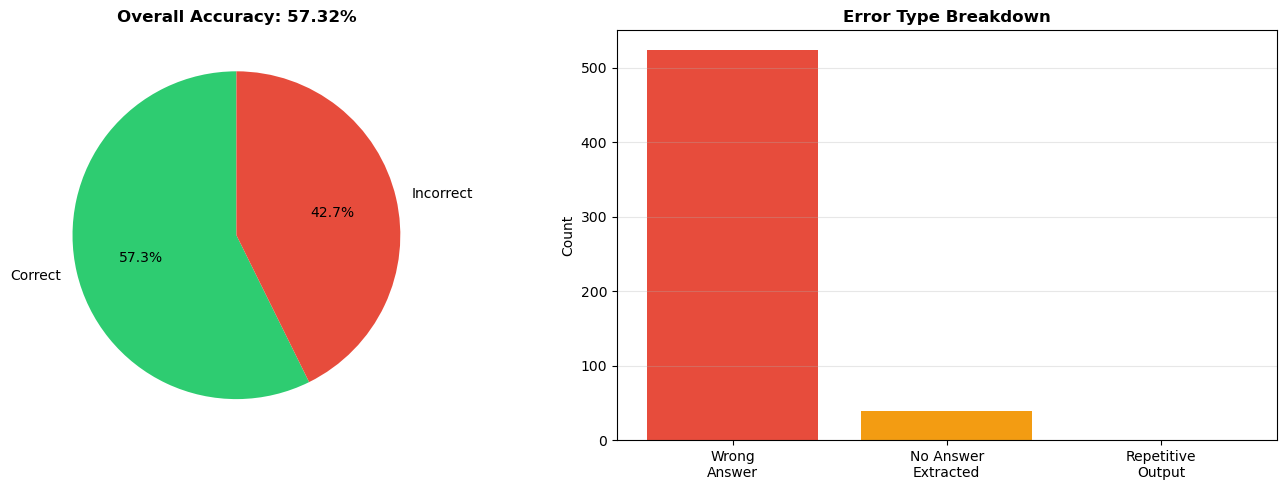


✓ Visualization saved to ./small_project/vanilla_sft/evaluation_results.png

VANILLA SFT EXPERIMENT COMPLETE!
All results saved to: ./small_project/vanilla_sft/


In [19]:
# --- CELL 17: Analysis and Visualization ---
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Show correct predictions
correct_preds = [r for r in results_log if r['is_correct']]
if correct_preds:
    print(f"\n✓ CORRECT PREDICTIONS (showing up to 3):")
    for i, r in enumerate(correct_preds[:3]):
        print(f"\n{i+1}. Question: {r['question'][:100]}...")
        print(f"   Predicted: {r['predicted_answer']}")
        print(f"   Correct: {r['correct_answer']}")
        print(f"   Response: {r['response_preview']}...")

# Show errors
error_preds = [r for r in results_log if not r['is_correct']]
if error_preds:
    print(f"\n✗ INCORRECT PREDICTIONS (showing up to 3):")
    for i, r in enumerate(error_preds[:3]):
        print(f"\n{i+1}. Question: {r['question'][:100]}...")
        print(f"   Predicted: {r['predicted_answer']}")
        print(f"   Correct: {r['correct_answer']}")
        print(f"   Response: {r['response_preview']}...")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy pie chart
ax1.pie([error_analysis['correct'], error_analysis['wrong_answer'] + error_analysis['no_answer_extracted']], 
        labels=['Correct', 'Incorrect'], 
        autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'],
        startangle=90)
ax1.set_title(f'Overall Accuracy: {accuracy:.2%}', fontweight='bold')

# Error breakdown
error_types = ['Wrong\nAnswer', 'No Answer\nExtracted', 'Repetitive\nOutput']
error_counts = [error_analysis['wrong_answer'], error_analysis['no_answer_extracted'], error_analysis['repetitive_output']]
ax2.bar(error_types, error_counts, color=['#e74c3c', '#f39c12', '#9b59b6'])
ax2.set_ylabel('Count')
ax2.set_title('Error Type Breakdown', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/evaluation_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to {config.OUTPUT_DIR}/evaluation_results.png")

print("\n" + "="*80)
print("VANILLA SFT EXPERIMENT COMPLETE!")
print(f"All results saved to: {config.OUTPUT_DIR}/")
print("="*80)
